# ToMATo for protein conformation

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import re
from sklearn import manifold

## 1- Data loading and visualisation

### Data loading and conversion to usable format

In [1]:
xyz = open("aladip/aladip_implicit.xyz", "r")
k=0
for line in xyz:
    if k<10:
        print('>>> ', line)
        k+=1
    else:
        break
xyz.close()

>>>  24.949 24.689 25.193

>>>  24.881 24.824 25.159

>>>  24.769 24.855 25.208

>>>  24.959 24.901 25.083

>>>  24.917 25.034 25.028

>>>  24.919 25.132 25.141

>>>  24.991 25.083 24.904

>>>  24.974 25.201 24.867

>>>  25.077 24.998 24.830

>>>  25.143 25.022 24.700



In [2]:
xyz = open("aladip/dihedral.xyz", "r")
k=0
for line in xyz:
    if k<10:
        print('>>> ', line)
        k+=1
    else:
        break
xyz.close()

>>>    -2.7394562e+00   1.9710530e-01

>>>    -1.4092216e+00  -3.7683849e-02

>>>    -1.0991716e+00   1.5843425e-01

>>>    -2.6436599e+00  -6.8284164e-02

>>>    -1.2765906e+00  -2.6540122e-01

>>>    -2.2302756e+00   1.7024640e-02

>>>    -2.5553681e+00   2.2676463e-01

>>>    -1.7089955e+00  -7.4869730e-02

>>>    -1.9782164e+00  -1.7803117e-01

>>>    -1.4665155e+00  -2.8951271e-01



In [6]:
def read_xyz(filename, n_rows, n_columns):
    """
    Get coordinates from filename and return a vectorset with all the
    coordinates, in XYZ format.
    Parameters
    ----------
    filename : string
        Filename to read
    Returns
    -------
    atoms : list
        List of atomic types
    V : array
        (N,3) where N is number of atoms
    """

    f = open(filename, 'r')
    V = list()

    # Use the number of rows to not read beyond the end of a file
    for lines_read, line in enumerate(f):

        if lines_read == n_rows:
            break

        numbers = re.findall(r'[-]?\d+\.\d*(?:[Ee][-\+]\d+)?', line)
        numbers = [float(number) for number in numbers]

        if len(numbers) == n_columns:
            V.append(np.array(numbers))
        else:
            exit("Reading the .xyz file failed in line {0}. Please check the format.".format(lines_read + 2))

    f.close()
    V = np.array(V)
    return V

In [7]:
aladip_implicit = read_xyz("aladip/aladip_implicit.xyz", 14207380, 3)

In [11]:
dihedral = read_xyz("aladip/dihedral.xyz", 14207380, 2)

### Visualisation

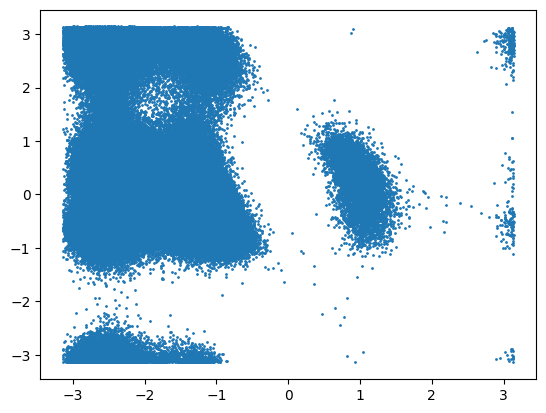

In [12]:
plt.scatter(dihedral[:,0], dihedral[:,1], s=1)
plt.show()

## 2- Compute RMSD distance matrix

### Helper functions

In [13]:
def quaternion_rotate(X, Y):
    """
    Calculate the rotation
    Parameters
    ----------
    X : array
        (N,D) matrix, where N is points and D is dimension.
    Y: array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rot : matrix
        Rotation matrix (D,D)
    """
    N = X.shape[0]
    W = np.asarray([makeW(*Y[k]) for k in range(N)])
    Q = np.asarray([makeQ(*X[k]) for k in range(N)])
    Qt_dot_W = np.asarray([np.dot(Q[k].T, W[k]) for k in range(N)])
    W_minus_Q = np.asarray([W[k] - Q[k] for k in range(N)])
    A = np.sum(Qt_dot_W, axis=0)
    eigen = np.linalg.eigh(A)
    r = eigen[1][:, eigen[0].argmax()]
    rot = quaternion_transform(r)
    return rot

def quaternion_transform(r):
    """
    Get optimal rotation
    note: translation will be zero when the centroids of each molecule are the
    same
    """
    Wt_r = makeW(*r).T
    Q_r = makeQ(*r)
    rot = Wt_r.dot(Q_r)[:3, :3]
    return rot


def makeW(r1, r2, r3, r4=0):
    """
    matrix involved in quaternion rotation
    """
    W = np.asarray([
             [r4, r3, -r2, r1],
             [-r3, r4, r1, r2],
             [r2, -r1, r4, r3],
             [-r1, -r2, -r3, r4]])
    return W


def makeQ(r1, r2, r3, r4=0):
    """
    matrix involved in quaternion rotation
    """
    Q = np.asarray([
             [r4, -r3, r2, r1],
             [r3, r4, -r1, r2],
             [-r2, r1, r4, r3],
             [-r1, -r2, -r3, r4]])
    return Q

def centroid(X):
    """
    Calculate the centroid from a vectorset X.
    https://en.wikipedia.org/wiki/Centroid
    Centroid is the mean position of all the points in all of the coordinate
    directions.
    C = sum(X)/len(X)
    Parameters
    ----------
    X : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    C : float
        centeroid
    """
    C = X.mean(axis=0)
    return C

def quaternion_rmsd(P, Q):
    """
    Rotate matrix P unto Q and calculate the RMSD
    based on doi:10.1016/1049-9660(91)90036-O
    Parameters
    ----------
    P : array
        (N,D) matrix, where N is points and D is dimension.
    P : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
    """
    rot = quaternion_rotate(P, Q)
    P = np.dot(P, rot)
    return rmsd(P, Q)

def rmsd(V, W):
    """
    Calculate Root-mean-square deviation from two sets of vectors V and W.
    Parameters
    ----------
    V : array
        (N,D) matrix, where N is points and D is dimension.
    W : array
        (N,D) matrix, where N is points and D is dimension.
    Returns
    -------
    rmsd : float
        Root-mean-square deviation
    """
    D = len(V[0])
    N = len(V)
    rmsd = 0.0
    for v, w in zip(V, W):
        rmsd += sum([(v[i] - w[i])**2.0 for i in range(D)])
    return np.sqrt(rmsd/N)

In [14]:
quaternion_rmsd(aladip_implicit[0:10],aladip_implicit[10:20])

0.07284970254320926

### Get subsample of the dataset

In [16]:
conformations = []
for k in range(int(len(aladip_implicit)/10)):
    conformations.append([aladip_implicit[k*10:(k+1)*10]])

In [17]:
len(conformations)

1420738

In [18]:
conform_sample = []
for k in range(len(conformations)):
    if k%400 == 0:
        conform_sample.append(conformations[k])

In [19]:
len(conform_sample)

3552

In [20]:
conform_sample[5][0]

array([[24.888, 24.699, 25.135],
       [24.965, 24.807, 25.063],
       [25.085, 24.797, 25.042],
       [24.89 , 24.915, 25.038],
       [24.925, 25.016, 24.95 ],
       [24.798, 25.078, 24.899],
       [25.009, 25.132, 25.012],
       [25.058, 25.222, 24.944],
       [25.023, 25.126, 25.149],
       [25.078, 25.235, 25.225]])

### Compute matrix

In [21]:
RMSD_m_sample = np.zeros((len(conform_sample), len(conform_sample)))
for k in range(len(conform_sample)):
    print(k)
    for i in range(len(conform_sample)):
        RMSD_m_sample[k, i] = quaternion_rmsd(np.array(conform_sample[k][0]), np.array(conform_sample[i][0]))

print(RMSD_m_sample)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
[[0.         0.26014788 0.17302537 ... 1.04807528 1.04042741 1.0378191 ]
 [0.26014788 0.         0.23267578 ... 1.01306304 1.01054558 1.03665676]
 [0.17302537 0.23267578 0.         ... 1.01313384 1.01014416 1.03525042]
 ...
 [1.04807528 1.01306304 1.01313384 ... 0.         0.11696621 0.2404695 ]
 [1.04042741 1.01054558 1.01014416 ... 0.11696621 0.         0.25916949]
 [1.0378191  1.03665676 1.03525042 ... 0.2404695  0.25916949 0.        ]]


In [23]:
print(len(RMSD_m_sample))
print(len(RMSD_m_sample[0]))

3552
3552


In [24]:
with open('RMSD_matrix_every_400_not_shuffled.txt', 'w') as fp:
    for item in RMSD_m_sample:
        # write each item on a new line
        fp.write("%s\n" % item)
    print('Done')

Done


## 3- Produce embedding in 2 dimensions

### Apply MDS to produce 2D embedding of the RMSD matrix

In [25]:
mds_model = manifold.MDS(n_components = 2, random_state = 123,
    dissimilarity = 'precomputed')
mds_fit = mds_model.fit(RMSD_m_sample)  
mds_coords = mds_model.fit_transform(RMSD_m_sample) 

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


### Visualise

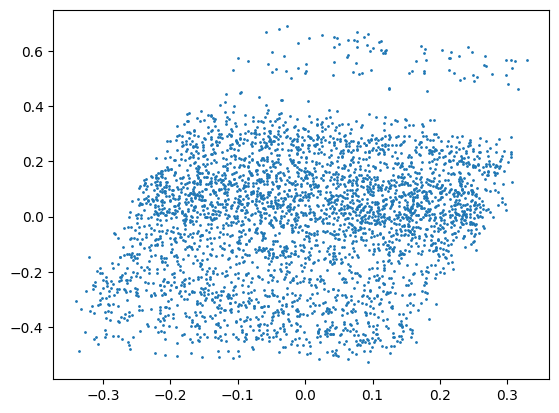

In [26]:
plt.scatter(mds_coords[:,0],mds_coords[:,1], s=1)
plt.show()

## 4- ToMATo